In [1]:
#pip install rasterio
#!pip install seaborn

In [2]:
# --- Imports ---
import os
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
# =========================
# Config — edit these only
# =========================
SERIES_1_NAME = "2025 - 2019 (Original)"     # <-- Your preferred label for series 1
SERIES_2_NAME = "2025 - Updated 2019"        # <-- Your preferred label for series 2

DIR_1 = r'P:\2025\NOGAL CANYON\02_PRODUCTION\04_QA_QC\SURFACE_COMPARE\2025 - 2019\Raster'
FILE_NAME_1 = 'DEM_diff'

DIR_2 = r'P:\2025\NOGAL CANYON\02_PRODUCTION\04_QA_QC\SURFACE_COMPARE\2025 - Updated 2019\Raster'
FILE_NAME_2 = 'DTM2025-minus-1100980_XDTM_clipped'

HISTOGRAM_TITLE = "Histogram of Raster Pixel Values (2025 vs 2019)"
LOWER_RANGE = -5.0
UPPER_RANGE =  5.0
NUM_BINS = 60                 # number of bars
Y_LIM_PERCENT = 40            # Y-axis max as percent (e.g., 40 = 40%)

In [4]:
# =========================
# Helper functions
# =========================
def read_valid_pixels(raster_path):
    """Read first band as masked array; return 1D numpy array of valid pixels (NoData removed)."""
    with rasterio.open(raster_path) as src:
        arr = src.read(1, masked=True)  # respects NoData and masks it out
    return arr.compressed().astype(float)  # 1D array, valid pixels only

def filter_range(values, lo, hi):
    """Filter values to [lo, hi]. Returns filtered values and % outside range."""
    values = np.asarray(values)
    if values.size == 0:
        return values, 0.0
    mask = (values >= lo) & (values <= hi)
    filtered = values[mask]
    pct_outside = 100.0 * (1.0 - (len(filtered) / len(values)))
    return filtered, pct_outside

def compute_stats(values):
    """Return min, max, mean, std for a 1D numpy array."""
    if len(values) == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    return (np.min(values), np.max(values), np.mean(values), np.std(values, ddof=1))

def percent_formatter(y, _):
    return f"{int(round(y))}%"



In [5]:
# =========================
# Load and prepare data
# =========================

RASTER_FILE_1 = os.path.join(DIR_1, FILE_NAME_1 + '.tif')
RASTER_FILE_2 = os.path.join(DIR_2, FILE_NAME_2 + '.tif')

vals1 = read_valid_pixels(RASTER_FILE_1)
vals2 = read_valid_pixels(RASTER_FILE_2)

# Filter to range
f1, pct_out_1 = filter_range(vals1, LOWER_RANGE, UPPER_RANGE)
f2, pct_out_2 = filter_range(vals2, LOWER_RANGE, UPPER_RANGE)

# Shared bins for fair comparison
bins = np.linspace(LOWER_RANGE, UPPER_RANGE, NUM_BINS + 1)

# Stats
min1, max1, mean1, std1 = compute_stats(f1)
min2, max2, mean2, std2 = compute_stats(f2)

n1 = len(f1)
n2 = len(f2)

# Weights to plot frequency as percentage
w1 = np.ones(n1) * 100.0 / n1 if n1 > 0 else None
w2 = np.ones(n2) * 100.0 / n2 if n2 > 0 else None



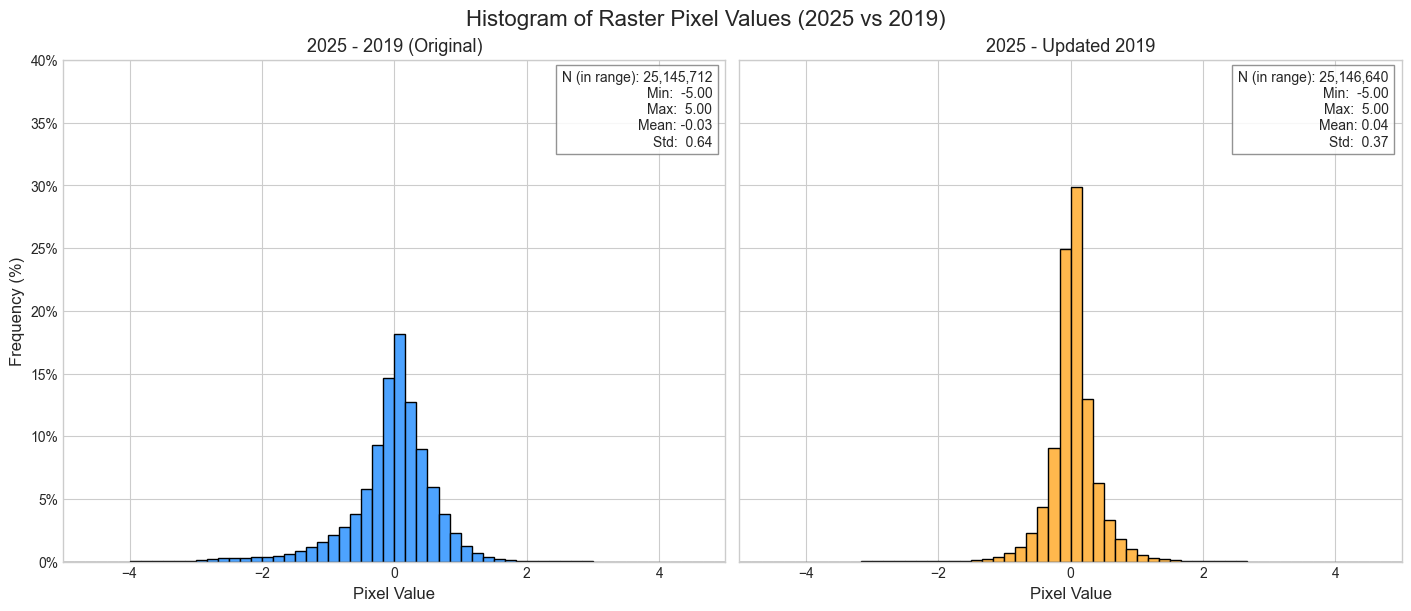

In [6]:
# =========================
# Plot: side-by-side histograms
# =========================
plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True, constrained_layout=True)

# Left subplot (Series 1)
ax1 = axes[0]
if n1 > 0:
    ax1.hist(f1, bins=bins, weights=w1, color='#4DA3FF', edgecolor='black')
ax1.set_title(SERIES_1_NAME, fontsize=13)
ax1.set_xlabel('Pixel Value', fontsize=12)
ax1.set_ylabel('Frequency (%)', fontsize=12)
ax1.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax1.set_xlim(LOWER_RANGE, UPPER_RANGE)
ax1.set_ylim(0, Y_LIM_PERCENT)
stats_text_1 = (
    f"N (in range): {n1:,}\n"
    f"Min:  {min1:.2f}\n"
    f"Max:  {max1:.2f}\n"
    f"Mean: {mean1:.2f}\n"
    f"Std:  {std1:.2f}"
)
ax1.text(0.98, 0.98, stats_text_1, transform=ax1.transAxes,
         va='top', ha='right', fontsize=10,
         bbox=dict(facecolor='white', alpha=0.85, edgecolor='gray'))

# Right subplot (Series 2)
ax2 = axes[1]
if n2 > 0:
    ax2.hist(f2, bins=bins, weights=w2, color='#FFB84D', edgecolor='black')
ax2.set_title(SERIES_2_NAME, fontsize=13)
ax2.set_xlabel('Pixel Value', fontsize=12)
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.set_xlim(LOWER_RANGE, UPPER_RANGE)
ax2.set_ylim(0, Y_LIM_PERCENT)
stats_text_2 = (
    f"N (in range): {n2:,}\n"
    f"Min:  {min2:.2f}\n"
    f"Max:  {max2:.2f}\n"
    f"Mean: {mean2:.2f}\n"
    f"Std:  {std2:.2f}"
)
ax2.text(0.98, 0.98, stats_text_2, transform=ax2.transAxes,
         va='top', ha='right', fontsize=10,
         bbox=dict(facecolor='white', alpha=0.85, edgecolor='gray'))

# Suptitle
fig.suptitle(HISTOGRAM_TITLE, fontsize=16)

plt.show()

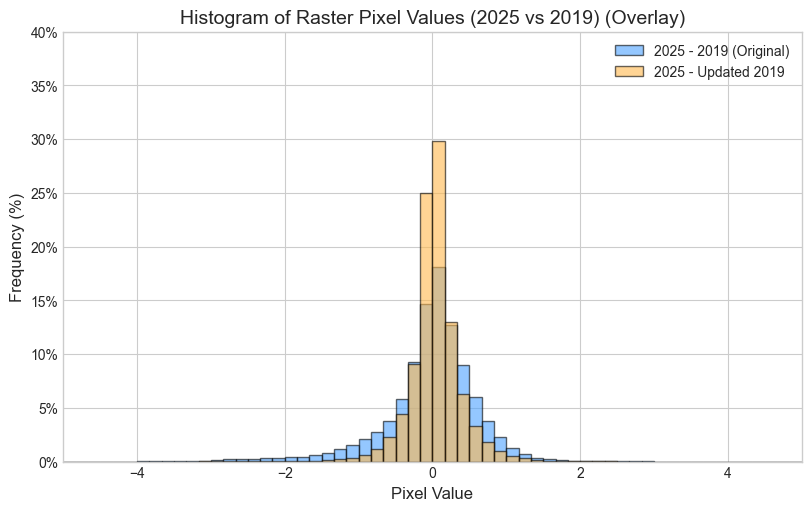

In [7]:
fig2, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
if n1 > 0:
    ax.hist(f1, bins=bins, weights=w1, color='#4DA3FF', alpha=0.6, label=SERIES_1_NAME, edgecolor='black')
if n2 > 0:
    ax.hist(f2, bins=bins, weights=w2, color='#FFB84D', alpha=0.6, label=SERIES_2_NAME, edgecolor='black')
ax.set_title(HISTOGRAM_TITLE + " (Overlay)", fontsize=14)
ax.set_xlabel('Pixel Value', fontsize=12)
ax.set_ylabel('Frequency (%)', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax.set_xlim(LOWER_RANGE, UPPER_RANGE)
ax.set_ylim(0, Y_LIM_PERCENT)
ax.legend()
plt.show()
